In [633]:
import numpy as np
import math
import copy
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from tqdm import tqdm
from scipy.fft import dct
import scipy

# Classification

In [634]:
ambientDimension = 128
# sigma = 0.25 # noise power
numAvg = int(1 * 1e+0) # number of experiment average
num_sample = 32
max_d = ambientDimension
num_para_list = [int(x) for x in np.linspace(1, ambientDimension, 20)]

# Data generation model:
featureMean = np.zeros(ambientDimension)
DCT = dct(np.identity(ambientDimension), axis=0, norm='ortho')
# 1. betaStar has most of its energy concentrated at the first 20 dct components
betaStar = 0
eff_dim = 20
coef = 0.02 + np.zeros(ambientDimension)
for i in range(eff_dim):
    coef[i] = np.sqrt((1 - (0.02 ** 2) * (ambientDimension - eff_dim)) / eff_dim)
for i in range(ambientDimension):
    betaStar += coef[i] * DCT[:,i]
betaStar = betaStar.reshape(-1,1)
# 2. input data distribution
Sigma = np.identity(ambientDimension)
decay = .9
snr = 1
for i in range(ambientDimension):
    Sigma[i, i] = decay ** (i - 1)
featureCov = DCT.dot(Sigma).dot(DCT.T)
leading_factor = (LA.norm(betaStar))**4 / betaStar.T.dot(featureCov).dot(betaStar)[0][0] / snr
featureCov = leading_factor * featureCov




# Training model
# cosine dct model (perfect model)
U = DCT
# hadamard model (misspecified model)
#U = scipy.linalg.hadamard(ambientDimension)
#U = U / np.sqrt(ambientDimension)


In [635]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    idm = np.identity(d)
    S = LA.pinv(X.T.dot(X) + n * ridge * idm).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    #d = X.shape[1]
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    a = 0
    Z = a * Cov + (1 - a) * ((1-p) * Cov + p * diag)
    S = LA.pinv(Z).dot((1 - p) * X.T)
    return S.dot(y)

# Risk

def get_risk(beta):
    z = np.inner(beta.reshape(-1), betaStar.reshape(-1)) / math.sqrt(2) / math.sqrt(beta.T.dot(featureCov).dot(beta)[0])
    #print(z, LA.norm(beta), np.inner(beta.reshape(-1), betaStar.reshape(-1)), math.sqrt(beta.T.dot(featureCov).dot(beta)[0]))
    return 0.5 * (1 - math.erf(z))

def get_exp_risk(para_ridge_list, para_crop_list):
    risk_ridge = np.zeros([len(num_para_list), len(para_ridge_list)])
    risk_crop = np.zeros([len(num_para_list), len(para_crop_list)])
    riskLSE = np.zeros(len(num_para_list))
    Z = np.zeros([num_sample, ambientDimension])
    y = np.zeros([num_sample, 1])
    for i in range(num_sample):
        z = random.random()
        y[i, 0] = -1 if z <= 0.5 else 1
        Z[i, :] = (betaStar * y[i, 0] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        feature = Z.dot(U)
    for idx, t in enumerate(num_para_list):
        X = feature[:,:t+1]
        # baseline LSE
        beta_est = get_lse_est(X, y)
        riskLSE[idx] = get_risk(U[:,:t+1].dot(beta_est))
        
        for j in range(len(para_ridge_list)):
            beta_est = get_ridge_est(X, y, para_ridge_list[j])
            risk_ridge[idx, j] = get_risk(U[:,:t+1].dot(beta_est))
        for j in range(len(para_crop_list)):
            beta_est = get_crop_est(X, y, para_crop_list[j])
            risk_crop[idx, j] = get_risk(U[:,:t+1].dot(beta_est))
    return risk_ridge, risk_crop, riskLSE

In [636]:
# Choose the type of augmentation:

# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
ridge_params = np.power(2, np.linspace(-10, 20, num=10))
crop_params = np.concatenate((np.linspace(0, 0.4, num=4), np.linspace(.5, .99, num=5)))


In [637]:
risk_ridge = np.zeros([len(num_para_list), len(ridge_params)])
risk_crop = np.zeros([len(num_para_list), len(crop_params)])
risk_lse = np.zeros(len(num_para_list))

# Simulate risk
avg_num = int(1e+1)
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):
    a, b, c = get_exp_risk(ridge_params, crop_params)
    risk_ridge += a
    risk_crop += b
    risk_lse += c
risk_ridge /= avg_num
risk_crop /= avg_num
risk_lse /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Complete in 6.12 sec


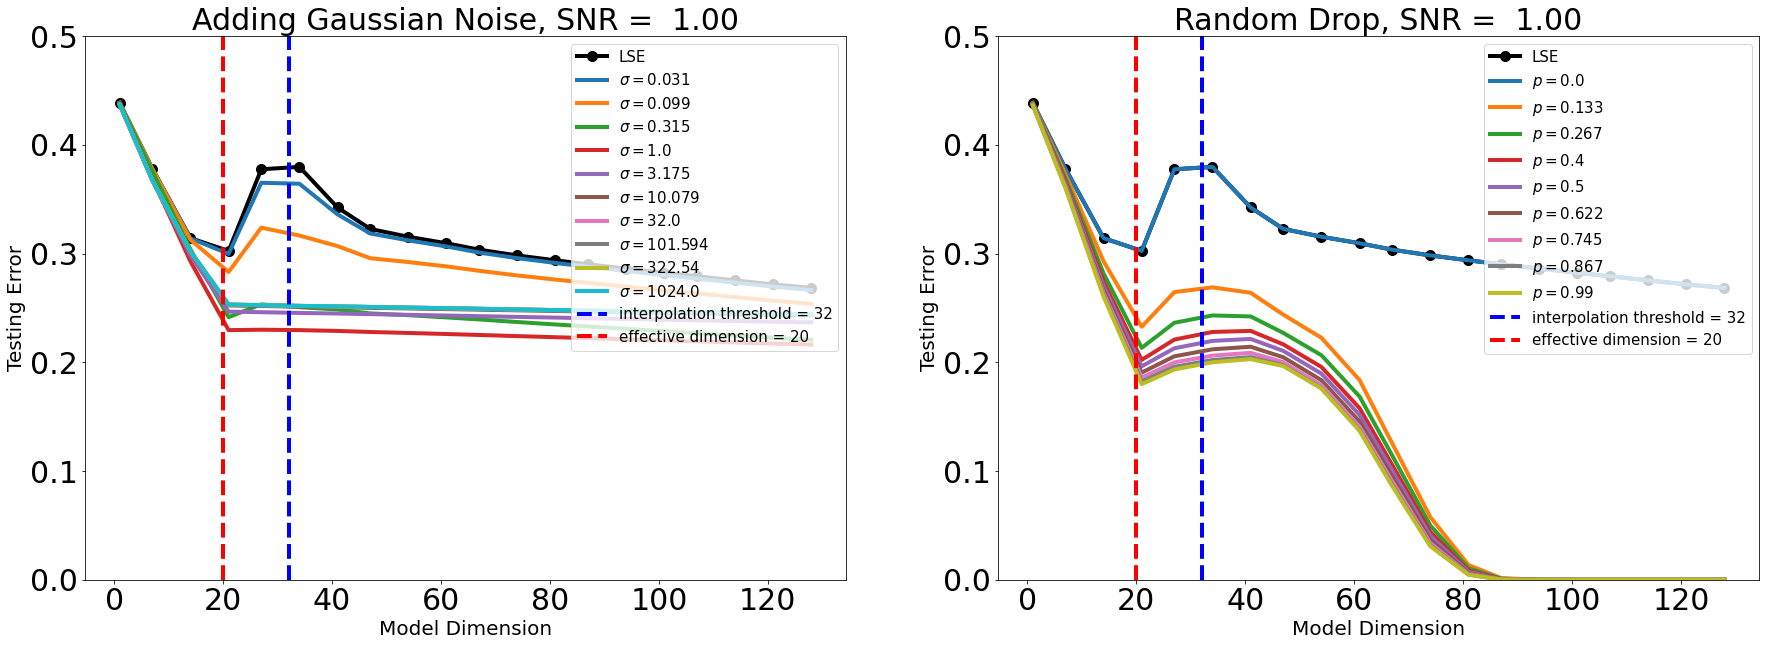

In [638]:
import seaborn as sns

plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
x_ax = num_para_list
plt.plot(x_ax, risk_lse, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0)
for i in range(len(ridge_params)):
    plt.plot(x_ax, risk_ridge[:,i], label=r'$\sigma=$'+str(round(np.sqrt(ridge_params[i]),3)), linewidth=4.0) # Gaussian noise
    #plt.yscale("log")
plt.axvline(x=num_sample, label='interpolation threshold = ' + str(num_sample), c='blue', ls='--', linewidth=4.0)
plt.axvline(x=eff_dim, label='effective dimension = ' + str(eff_dim), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Model Dimension', fontsize=20)
plt.ylabel('Testing Error', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title(f"Adding Gaussian Noise, SNR = {snr: 0.2f}", fontsize=30)
plt.ylim(0, 0.5)

plt.subplot(1,2,2)
plt.plot(x_ax, risk_lse, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0)
for i in range(0, len(crop_params)):
    plt.plot(x_ax, risk_crop[:,i],label=r'$p=$'+str(round(crop_params[i],3)), linewidth=4.0) # Random crop
    #plt.yscale("log")
plt.axvline(x=num_sample, label='interpolation threshold = ' + str(num_sample), c='blue', ls='--', linewidth=4.0)
plt.axvline(x=eff_dim, label='effective dimension = ' + str(eff_dim), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Model Dimension', fontsize=20)
plt.ylabel('Testing Error', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title(f"Random Drop, SNR = {snr: 0.2f}", fontsize=30)
plt.ylim(0, 0.5)
plt.show()


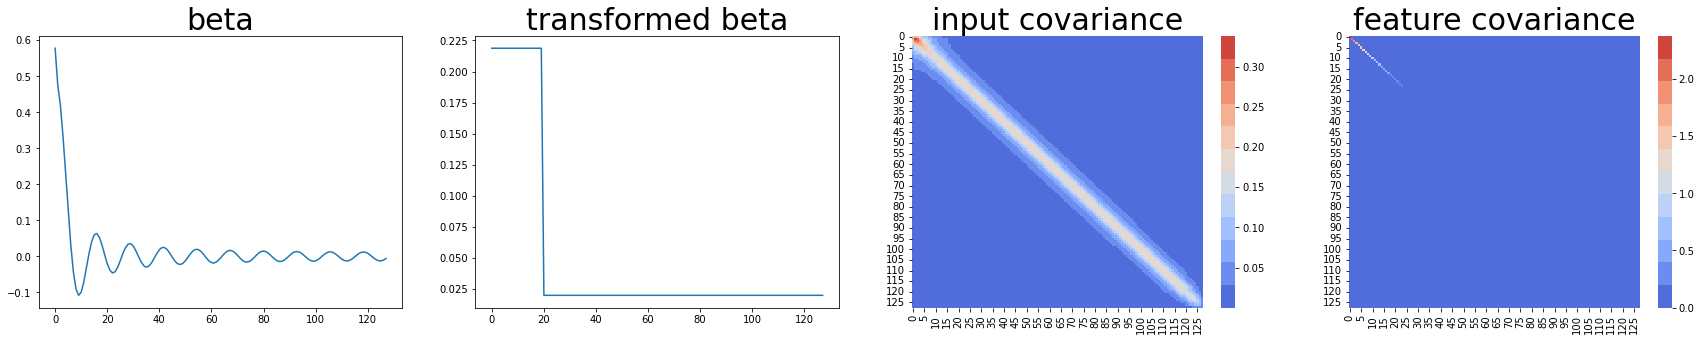

In [639]:
plt.figure(figsize=(30, 5))
plt.subplot(1,4,1)
plt.plot(betaStar)
plt.title("beta", fontsize=30)
plt.subplot(1,4,2)
plt.plot(U.T.dot(betaStar))
plt.title("transformed beta", fontsize=30)

xis = np.linspace(5, ambientDimension, 5)
ax = plt.subplot(1,4,3)
sns.heatmap(featureCov, cmap=sns.color_palette("coolwarm", 12), ax=ax)
ax.set_title('input covariance', fontsize=30)
ax = plt.subplot(1,4,4)
sns.heatmap(U.T.dot(featureCov).dot(U), cmap=sns.color_palette("coolwarm", 12), ax=ax)
ax.set_title('feature covariance', fontsize=30)

plt.show()

In [640]:
snr = (LA.norm(betaStar))**4 / betaStar.T.dot(featureCov).dot(betaStar)[0][0]
print(f"SNR = {snr}")

SNR = 0.9999999999999998
